<a href="https://colab.research.google.com/github/cyan9212/Dacon_KBO_Batter_OPS/blob/main/KBO_%ED%83%80%EC%9E%90_OPS%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
from matplotlib import font_manager, rc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import platform

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
# matplotlib 폰트 변경
plt.rc('font', family='NanumBarunGothic') 

# 그래프에서 마이너스 기호가 표시되도록 설정
matplotlib.rcParams['axes.unicode_minus'] = False

#Colab Notebook에 파일 업로드 
uploader = files.upload()

Saving Pre_Season_Batter.csv to Pre_Season_Batter (1).csv
Saving Regular_Season_Batter.csv to Regular_Season_Batter (1).csv
Saving Regular_Season_Batter_Day_by_Day_b4.csv to Regular_Season_Batter_Day_by_Day_b4 (1).csv
Saving submission.csv to submission (1).csv


# 1. EDA

**1.1 프리시즌 데이터 분석**

In [ ]:
#프리시즌 데이터 로드 
preseason_df = pd.read_csv('Pre_Season_Batter.csv')

#정규시즌 데이터 로드
regular_season_df = pd.read_csv('Regular_Season_Batter.csv')

#데이터 크기 확인
print(preseason_df.shape)

#데이터 상단 출력
preseason_df.head()

(1393, 29)


,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,0,1,11,5,0,0,2,0,3,1,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959
1,1,강경학,2011,한화,0.000,4,2,2,0,0,0,0,0,1,0,1,0,2,1,0,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500
2,1,강경학,2014,한화,-,4,0,2,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,NaN
3,1,강경학,2015,한화,0.130,10,23,3,3,0,0,0,3,1,3,0,4,1,9,0,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416
4,1,강경학,2016,한화,0.188,14,32,4,6,1,1,0,9,2,1,2,0,1,10,0,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493


In [ ]:
# 데이터 기초통계량 확인
display(preseason_df.describe())

,batter_id,year,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1364.000000,1368.000000,1393.000000,1364.000000
mean,173.434314,2013.014358,8.705671,19.201723,2.679828,5.021536,0.954774,0.119885,0.391960,7.391960,2.430725,0.629576,0.291457,1.877961,0.330223,3.714286,0.447236,0.361012,0.317912,0.381910,0.676924
std,94.716851,4.166757,5.562686,13.395946,2.637212,4.232584,1.196904,0.379976,0.748557,6.538787,2.698122,1.146854,0.595522,2.053392,0.642204,3.180884,0.723364,0.269892,0.151489,0.729521,0.386933
min,0.000000,2002.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99.000000,2010.000000,6.000000,9.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.217000,0.250000,0.000000,0.472000
50%,178.000000,2014.000000,9.000000,18.000000,2.000000,4.000000,1.000000,0.000000,0.000000,6.000000,2.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.344500,0.333000,0.000000,0.675000
75%,254.000000,2017.000000,11.000000,28.000000,4.000000,8.000000,2.000000,0.000000,1.000000,11.000000,4.000000,1.000000,0.000000,3.000000,1.000000,5.000000,1.000000,0.478000,0.400000,1.000000,0.867000
max,344.000000,2018.000000,119.000000,183.000000,35.000000,51.000000,11.000000,4.000000,5.000000,68.000000,24.000000,9.000000,4.000000,21.000000,4.000000,36.000000,5.000000,4.000000,1.000000,5.000000,5.000000


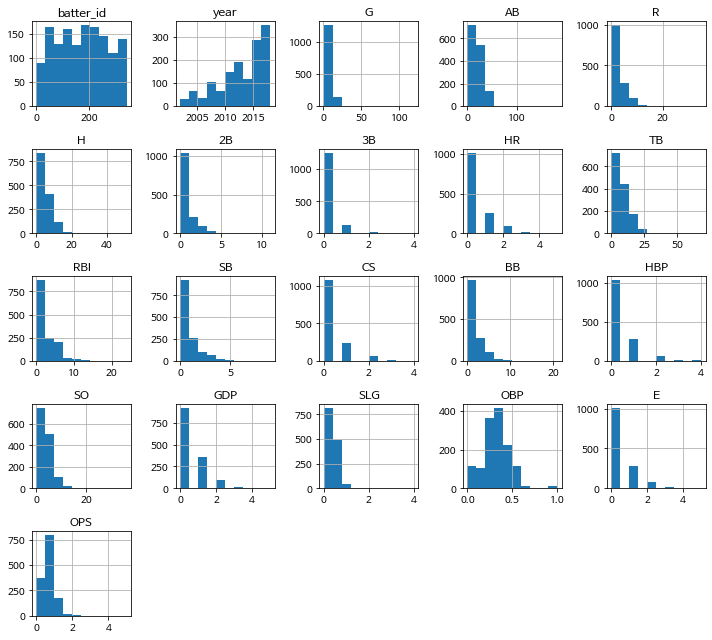

In [ ]:
# 데이터 시각화
preseason_df.hist(figsize=(10, 9))
plt.tight_layout() # 그래프 간격 설정
plt.show()

2B, 3B, AB, BB, CS, SLG, R, TB 등 대부분의 값이 0에 가까운 낮은 값을 기록한 것을 확인할 수 있고 

이는 프리시즌의 경기 수가 적어서 나타나는 현상이라고 추측 가능하다. 

연도의 분포를 살펴보면 과거로 갈수록 기록의 수가 적어지는 것을 확인할 수 있으며, 

이는 과거의 데이터일수록 기록한 데이터 수가 적음을 의미한다.

In [ ]:
# 정규시즌 데이터에서 2002년 이후의 연도별 기록된 선수의 수
regular_count = regular_season_df.groupby('year')['batter_id'].count().rename('regular')

# 프리스즌 데이터에서 연도별 기록된 선수의 수
preseason_count = preseason_df.groupby('year')['batter_id'].count().rename('preseason')

pd.concat([regular_count, preseason_count, np.round(preseason_count/regular_count, 2).rename('ratio')], axis=1).transpose().loc[:,2002:]

year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
regular,43.00,54.00,68.00,73.00,85.00,98.00,115.00,124.00,130.00,151.0,174.0,194.00,186.00,207.00,213.00,217.00,227.0
preseason,12.00,19.00,28.00,37.00,36.00,43.00,61.00,66.00,72.00,75.0,87.0,104.00,117.00,134.00,153.00,167.00,182.0
ratio,0.28,0.35,0.41,0.51,0.42,0.44,0.53,0.53,0.55,0.5,0.5,0.54,0.63,0.65,0.72,0.77,0.8


In [ ]:
# 타자의 이름과 연도를 이용해 새로운 인덱스를 생성
regular_season_df['new_idx'] = regular_season_df['batter_name'] + regular_season_df['year'].apply(str)
preseason_df['new_idx'] = preseason_df['batter_name'] + preseason_df['year'].apply(str)

# 새로운 인덱스의 교집합
intersection_idx = list(set(regular_season_df['new_idx']).intersection(preseason_df['new_idx']))

# 교집합에 존재하는 데이터만 불러오기
regular_season_new = regular_season_df.loc[regular_season_df['new_idx'].apply(lambda x: x in intersection_idx)].copy()
preseason_new = preseason_df.loc[preseason_df['new_idx'].apply(lambda x: x in intersection_idx)].copy()

# 비교를 위해 인덱스로 정렬
regular_season_new = regular_season_new.sort_values(by='new_idx').reset_index(drop=True)
preseason_new = preseason_new.sort_values(by='new_idx').reset_index(drop=True)

# 검정 코드
print(regular_season_new.shape, preseason_new.shape)
sum(regular_season_new['new_idx'] == preseason_new['new_idx'])

(1358, 30) (1358, 30)


1358

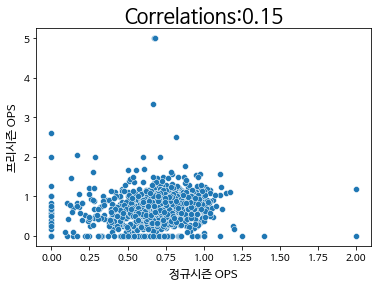

In [ ]:
# 정규시즌과 프리시즌의 상관관계 계산
correlation = regular_season_new['OPS'].corr(preseason_new['OPS'])
sns.scatterplot(x=regular_season_new['OPS'], y=preseason_new['OPS'])
plt.title('Correlations:'+str(np.round(correlation, 2)), fontsize=20)
plt.xlabel('정규시즌 OPS', fontsize=12)
plt.ylabel('프리시즌 OPS', fontsize=12)
plt.show()

정규시즌과 프리시즌의 성적 분포가 선형적인 모습일 띠고 있지 않으므로 서로 상관성이 낮음을 확인할 수 있다. 

대회의 예측 대상이 정규시즌의 성적이기 때문에 프리시즌 데이터를 이용하지 않는 것이 더 정밀한 결과를 도출할것

**1.2 정규시즌 데이터 분석**

In [ ]:
regular_season_df = pd.read_csv('Regular_Season_Batter.csv')
display(regular_season_df.shape, regular_season_df.head())
regular_season_df.describe()

(2454, 29)

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902
1,1,강경학,2011,한화,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000
2,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686
3,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673
4,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489


,batter_id,year,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,2454.000000,2454.000000,2428.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2428.000000,2430.000000,2454.000000,2428.000000
mean,178.079462,2011.614507,0.237559,72.535045,201.514670,29.912388,55.988183,9.863488,0.957620,5.504075,84.279136,27.788509,5.290139,2.335778,20.943765,3.424613,38.596985,4.603504,0.343826,0.306684,3.676447,0.649939
std,97.557947,4.992833,0.098440,45.093871,169.537029,28.778759,52.253844,9.871314,1.647193,7.989380,82.854200,29.602966,9.088580,3.194045,21.206113,4.132614,31.801466,4.713531,0.163335,0.111778,4.585248,0.261634
min,0.000000,1993.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,101.250000,2008.000000,0.203000,28.000000,38.250000,5.000000,8.000000,1.000000,0.000000,0.000000,10.000000,3.000000,0.000000,0.000000,3.000000,0.000000,10.000000,1.000000,0.267454,0.272727,0.000000,0.546000
50%,183.000000,2013.000000,0.255000,79.000000,163.000000,21.000000,40.000000,7.000000,0.000000,2.000000,56.000000,17.000000,2.000000,1.000000,14.000000,2.000000,33.000000,3.000000,0.360124,0.328592,2.000000,0.688637
75%,265.000000,2016.000000,0.291000,115.000000,357.500000,49.000000,100.000000,16.000000,1.000000,8.000000,146.000000,44.000000,6.000000,3.000000,34.000000,5.000000,60.000000,7.000000,0.436000,0.367000,5.000000,0.797234
max,344.000000,2018.000000,1.000000,144.000000,600.000000,135.000000,201.000000,47.000000,17.000000,53.000000,377.000000,146.000000,84.000000,21.000000,108.000000,27.000000,161.000000,24.000000,3.000000,1.000000,30.000000,4.000000


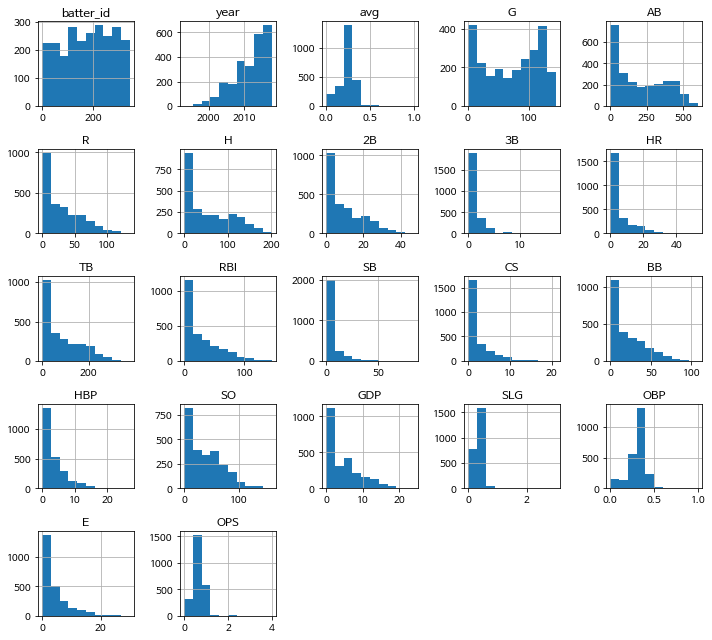

In [ ]:
# 정규시즌 데이터를 히스토그램으로 시각화
regular_season_df.hist(figsize=(10,9))
plt.tight_layout()
plt.show()

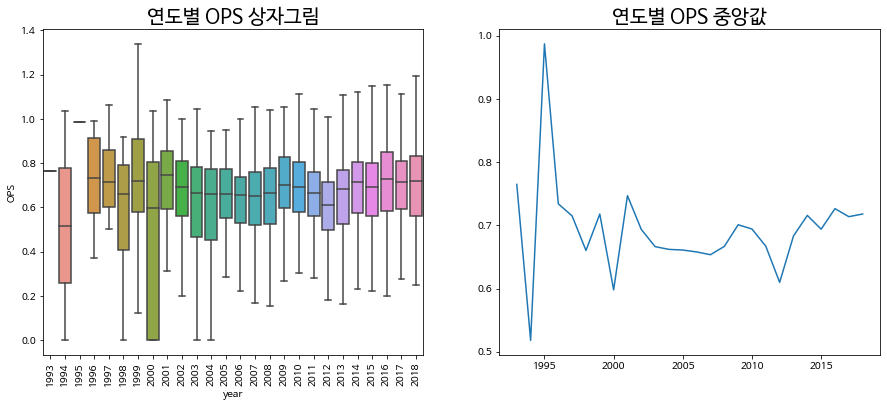

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
g = sns.boxplot(x='year', y='OPS', data=regular_season_df, showfliers=False)
g.set_title('연도별 OPS 상자그림', size=20)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.subplot(1, 2, 2)
plt.plot(regular_season_df.groupby('year')['OPS'].median())
plt.title('연도별 OPS 중앙값', size=20)
plt.show()

연도별 OPS의 분포를 상자그림을 통해 확인한 결과, 대부분 비슷한 형태를 띠고 있지만 연도별 중앙값을 살펴보면 2000년도를 기준으로  OPS의 변동이 차이가 있다.

2000년도 이전의 기록은 변동이 상당히 큰 것을 확인할 수 있고 그 이후로는 변동폭이 크지 않은 추세를 보인다.

In [ ]:
pd.crosstab(regular_season_df['year'], 'count').T

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
col_0,,,,,,,,,,,,,,,,,,,,,,,,,,
count,1,2,1,7,8,10,14,20,32,43,54,68,73,85,98,115,124,130,151,174,194,186,207,213,217,227


데이터를 확인할 결과 200년도 이전에는 기록의 상대적으로 매우 적었음을 알 수 있고

이 때문에 2000년도 이전 OPS의 변동 폭이 컸던 것임을 유추할 수 있다.

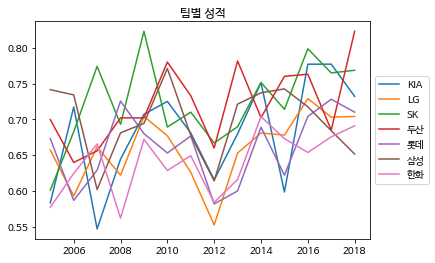

In [ ]:
# 연도별 팀의 OPS 중앙값 계산
med_OPS_team = regular_season_df.pivot_table(index=['team'], columns='year', values='OPS', aggfunc='median')

#2005년 이후에 결측치가 존재하지 않는 팀만 확인
team_idx = med_OPS_team.loc[:,2005:].isna().sum(axis=1) == 0

plt.plot(med_OPS_team.loc[team_idx, 2005:].T)
plt.legend(med_OPS_team.loc[team_idx, 2005:].T.columns, loc='center left', bbox_to_anchor=(1, 0.5)) # 그래프 범례를 그래프 밖에 위치
plt.title('팀별 성적')
plt.show()

In [ ]:
import re

regular_season_df['weight'] = regular_season_df['height/weight'].apply(lambda x: int(re.findall('\d+', x.split('/')[1])[0]) if pd.notnull(x) else x)
regular_season_df['height'] = regular_season_df['height/weight'].apply(lambda x: int(re.findall('\d+', x.split('/')[0])[0]) if pd.notnull(x) else x)

print(regular_season_df['height/weight'][0], regular_season_df['height'][0], regular_season_df['weight'][0])

177cm/93kg 177.0 93.0


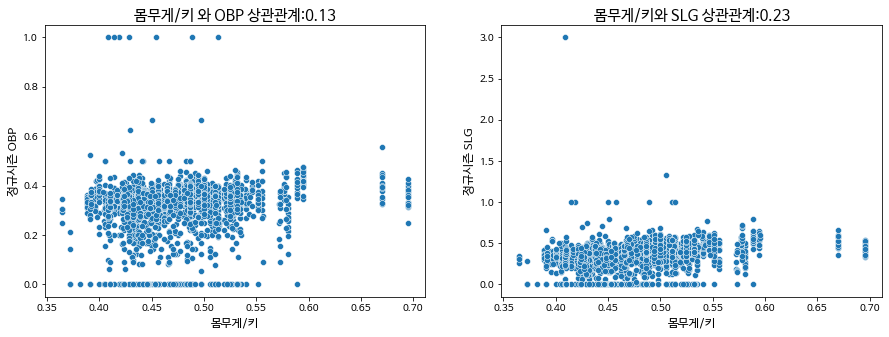

In [ ]:
# 몸무게/키 계산
regular_season_df['weight_per_height'] = regular_season_df['weight'] / regular_season_df['height']

# 그래프 크기 조정
plt.figure(figsize=(15, 5))

# 몸무게/키와 OBP의 상관관계 계산
plt.subplot(1, 2, 1)
correlation = regular_season_df['weight_per_height'].corr(regular_season_df['OBP'])
sns.scatterplot(x = regular_season_df['weight_per_height'], y = regular_season_df['OBP'])
plt.title('몸무게/키 와 OBP 상관관계:' + str(np.round(correlation, 2)), fontsize=15)
plt.ylabel('정규시즌 OBP', fontsize=12)
plt.xlabel('몸무게/키', fontsize=12)

# 몸무게/키와 SLG의 상관관계 계산
plt.subplot(1, 2, 2)
correlation = regular_season_df['weight_per_height'].corr(regular_season_df['SLG'])
sns.scatterplot(x = regular_season_df['weight_per_height'], y = regular_season_df['SLG'])
plt.title('몸무게/키와 SLG 상관관계:' + str(np.round(correlation, 2)), fontsize=15)
plt.xlabel('몸무게/키', fontsize=12)
plt.ylabel('정규시즌 SLG', fontsize=12)

plt.show()

데이터가 선형적인 모습을 띠지 않고 분포가 고르게 되어 있으므로 몸무게 및 키가 장타율과 출루율에 큰 영향을 미치지 않음을 확인할 수 있다.

In [ ]:
regular_season_df['position'].value_counts()

내야수(우투우타)    643
외야수(우투우타)    230
외야수(좌투좌타)    201
포수(우투우타)     189
외야수(우투좌타)    184
내야수(우투좌타)    141
내야수(좌투좌타)     36
포수(우투좌타)      14
내야수(우투양타)      7
외야수(우투양타)      7
Name: position, dtype: int64

In [ ]:
# position
regular_season_df['pos'] = regular_season_df['position'].apply(lambda x: x.split('(')[0] if pd.notnull(x) else x)

# 우타, 좌타, 양타
regular_season_df['hit_way'] = regular_season_df['position'].apply(lambda x: x[-3:-1] if pd.notnull(x) else x)

print(regular_season_df['position'][0], regular_season_df['pos'][0], regular_season_df['hit_way'][0])

내야수(우투우타) 내야수 우타


타자가 왼손잡이인지 오른손잡이인지, 수비 포지션은 어디인지를 구분

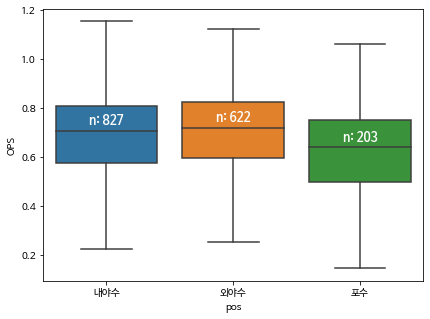

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ax = sns.boxplot(x='pos', y='OPS', data=regular_season_df, showfliers=False)

# position별 OPS 중앙값
medians = regular_season_df.groupby('pos')['OPS'].median().to_dict()

# position별 관측지 수
nobs = regular_season_df['pos'].value_counts().to_dict()

# 키 값을 'n: 값' 형식으로 변환
for key in nobs:
  nobs[key] = 'n: ' + str(nobs[key])

# 그래프의 Xticks text값 얻기
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]

# tick은 tick의 위치, label은 그에  해당하는 text 값
for label in ax.get_xticklabels():
  ax.text(xticks_labels.index(label.get_text()), medians[label.get_text()] + 0.03, nobs[label.get_text()], horizontalalignment='center', size='large', color='w', weight='semibold')

ax.settitle('포지션별 OPS')

plt.subplot(1, 2, 2)